In [60]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f

In [61]:
from functions import *

## **Import the EEG Data and set the Global Variables**

In [66]:
chan_name = ['PO3','PO2','PO4', 'PO7', 'POz', 'Oz', 'O2', 'PO8']
fs, lf, hf = 250, 1, 30 #Hz

eeg_data = process_folder('data/Liuyin-5April/Afternoon/', chan_name, target_freq='auto', hf=hf, lf=lf)

In [63]:
# # remove channels ['PO7', 'PO8']
# for eeg in eeg_data:
#     print(eeg.title)
#     eeg.remove_channels(['PO7', 'PO8'])

In [64]:
for eeg in eeg_data:
    amplitude_plot(eeg.filtered_signal, chan_name, title=(eeg.title))

NameError: name 'eeg_data' is not defined

In [ ]:
for eeg in eeg_data:
    eeg.cut_signal(15, 10, cut_to=False)

In [ ]:
# for eeg in eeg_data:
#     amplitude_plot(eeg.filtered_signal, chan_name, title=("Cut Filtered: "+eeg.title))

In [72]:
psd_plot_interactive(eeg_data, chan_name, nperseg_max=50, nfft_max=50,fig_x=15,fig_y=3, xmin=3, xlim=hf, ylim=75)

interactive(children=(IntSlider(value=20, description='nperseg*fs:', max=50, min=1), IntSlider(value=20, descr…

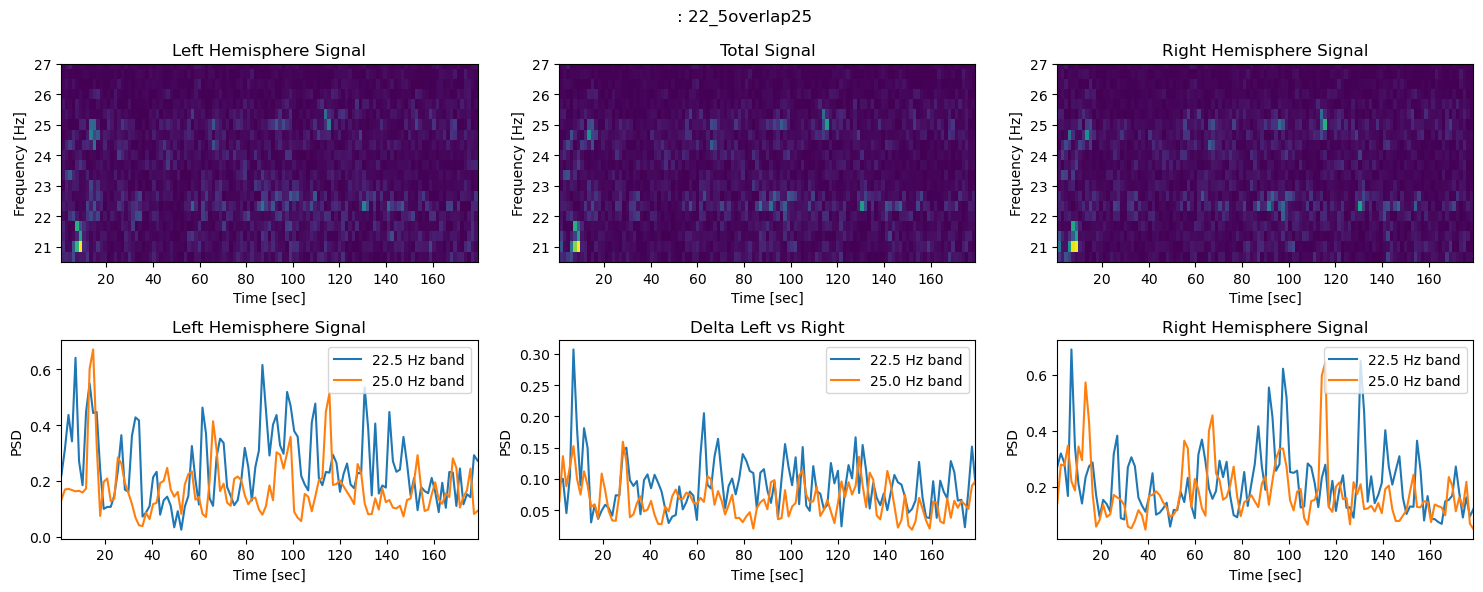

In [79]:
def chan_hemisphere(chan_name):
    # left hemisphere -> odd numbers (1,3,5,7) 
    left_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 != 0]
    # right hemisphere -> even numbers (2,4,6,8)
    right_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 == 0]
    # midline -> z
    midline_hemisphere = [chan for chan in chan_name if chan[-1] == 'z']
    return left_hemisphere, midline_hemisphere, right_hemisphere

def hemisphere_signal_avg(eeg, chan_name):
    left_hemisphere, midline_hemisphere, right_hemisphere = chan_hemisphere(chan_name)

    # seperate the signal into left and right hemisphere and take the average per channel
    left_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in left_hemisphere],:], axis=0)
    right_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in right_hemisphere],:], axis=0)
    midline_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in midline_hemisphere],:], axis=0)
    
    return left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal

def plot_spectrogram_and_bands(eeg,title=None, band_freqs=None, f_min=5, f_max=15, fs=250):
    if band_freqs:
        f_min = min(band_freqs) - 2
        f_max = max(band_freqs) + 2
    else:
        band_freqs = [f_min, f_max]
    total_signal = np.mean(eeg.filtered_signal, axis=0)
    left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal = hemisphere_signal_avg(eeg, chan_name)

    def masked_spectogram(singal, nperseg=3,nfft=3):
        frequencies, times, spectrogram = signal.spectrogram(singal, fs=fs, nperseg=fs*nperseg, noverlap=fs*nperseg/2, scaling='spectrum', mode='psd', nfft=fs*nfft)
        mask = (frequencies >= f_min) & (frequencies <= f_max)
        spectrogram_masked = spectrogram[mask, :]
        frequencies_masked = frequencies[mask]
        return frequencies_masked, times, spectrogram_masked
    
    # Plot the spectrogram using matplotlib
    
    # fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(15, 6))
    fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(15, 6))
    def plot_sepctro(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal, nperseg=3,nfft=3)
        ax.pcolormesh(times, frequencies_masked, spectrogram_masked)
        ax.set_ylim(f_min, f_max)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        ax.set_title(title)
    
    # plot spectro per each channel in a 2 by 4
    # for i, chan in enumerate(chan_name):
    #     if i < 4:
    #         plot_sepctro(axs[0,i], eeg.filtered_signal[i,:], chan)
    #     else:
    #         plot_sepctro(axs[1,i-4], eeg.filtered_signal[i,:], chan)


    plot_sepctro(axs[0,0], left_hemisphere_signal, 'Left Hemisphere Signal')
    plot_sepctro(axs[0,1], total_signal, 'Total Signal')
    plot_sepctro(axs[0,2], right_hemisphere_signal, 'Right Hemisphere Signal')

    def plot_bands(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal)
        # Plot the PSDs in the frequency bands of interest through time
        for i, band_freq in enumerate(band_freqs):
            band_mask = (frequencies_masked >= band_freq-1) & (frequencies_masked <= band_freq+1)
            psd = np.mean(spectrogram_masked[band_mask, :], axis=0)
            ax.plot(times, psd, label=f'{band_freqs[i]} Hz band')
        ax.set_xlim(times[0], times[-1])
        ax.set_xlabel('Time [sec]')
        ax.set_ylabel('PSD')
        ax.legend()
        ax.set_title(title)

    if band_freqs:
        plot_bands(axs[1,0], left_hemisphere_signal, 'Left Hemisphere Signal')
        plot_bands(axs[1,1], left_hemisphere_signal-right_hemisphere_signal, 'Delta Left vs Right')
        plot_bands(axs[1,2], right_hemisphere_signal, 'Right Hemisphere Signal')
    
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
for eeg in eeg_data: 
    if('22_5overlap25' in eeg.title):
        plot_spectrogram_and_bands(eeg, title = eeg.title, band_freqs=eeg.stimulus_frequency)   

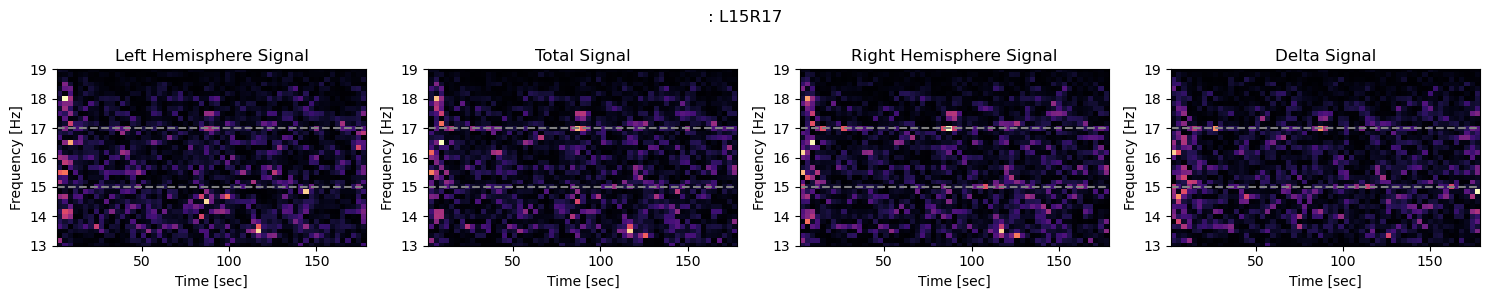

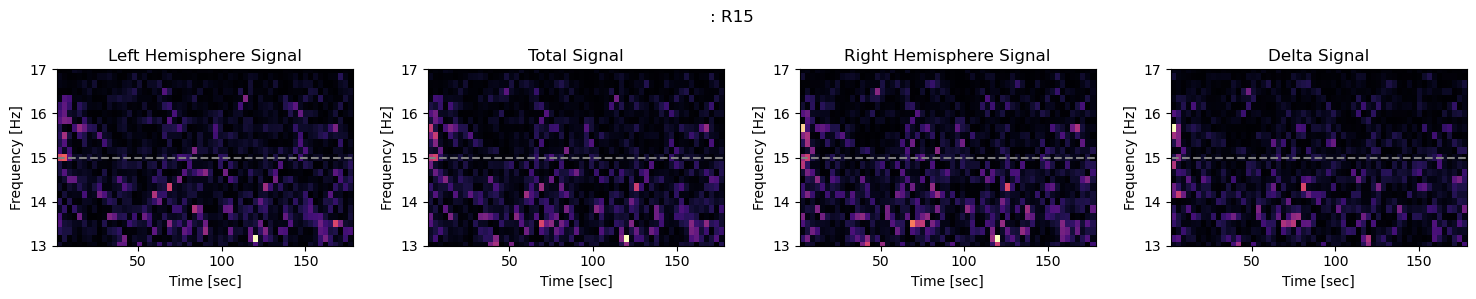

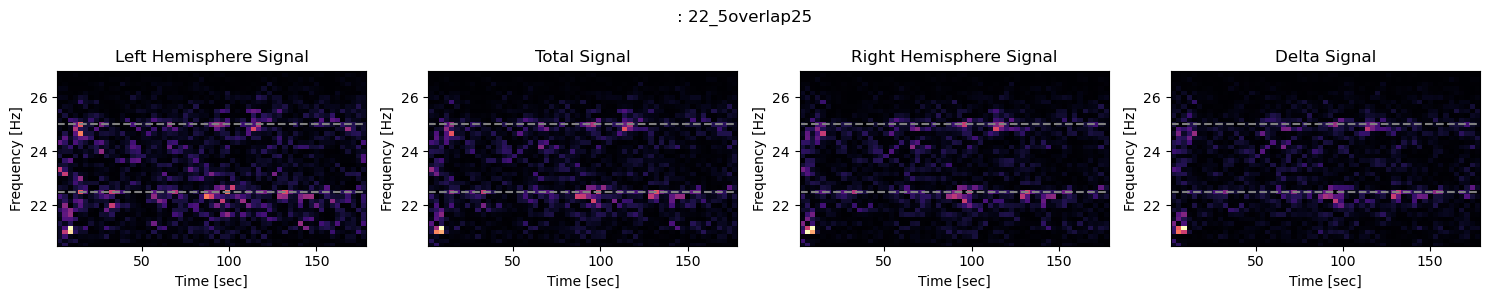

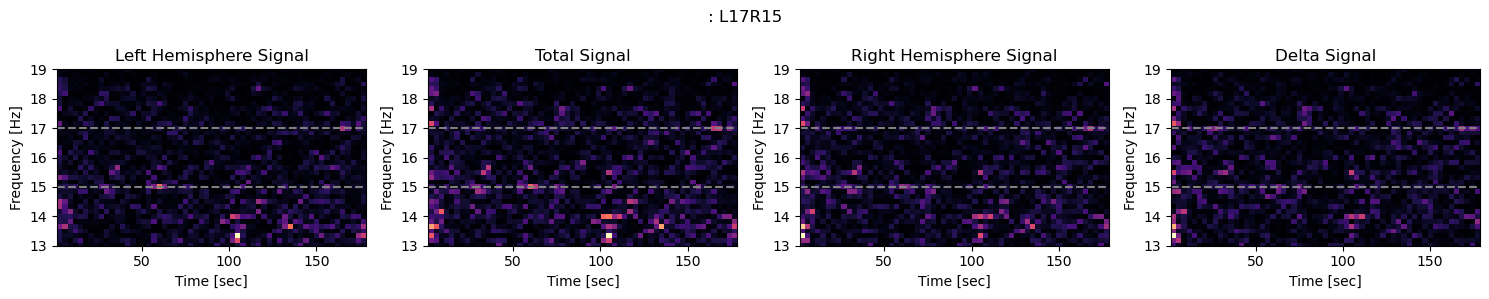

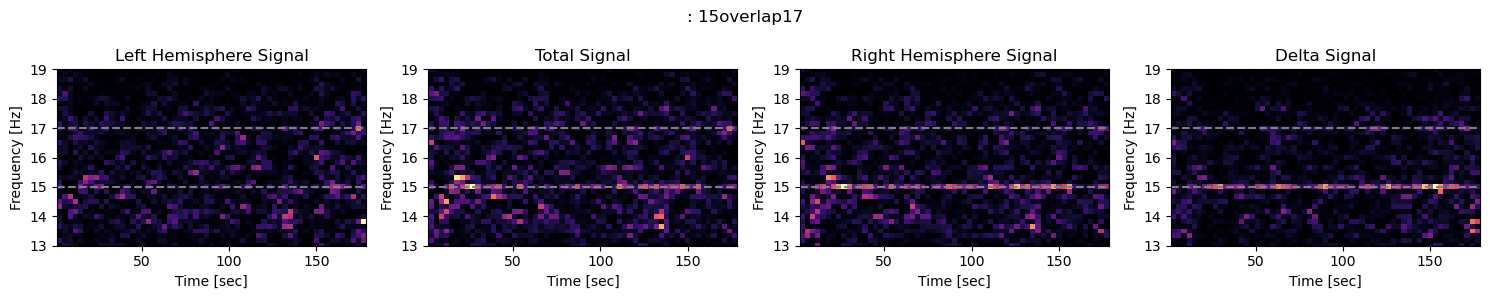

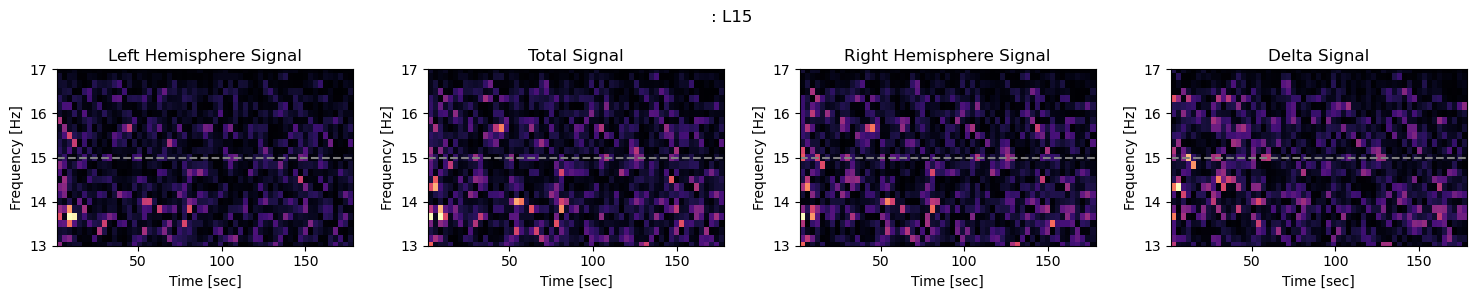

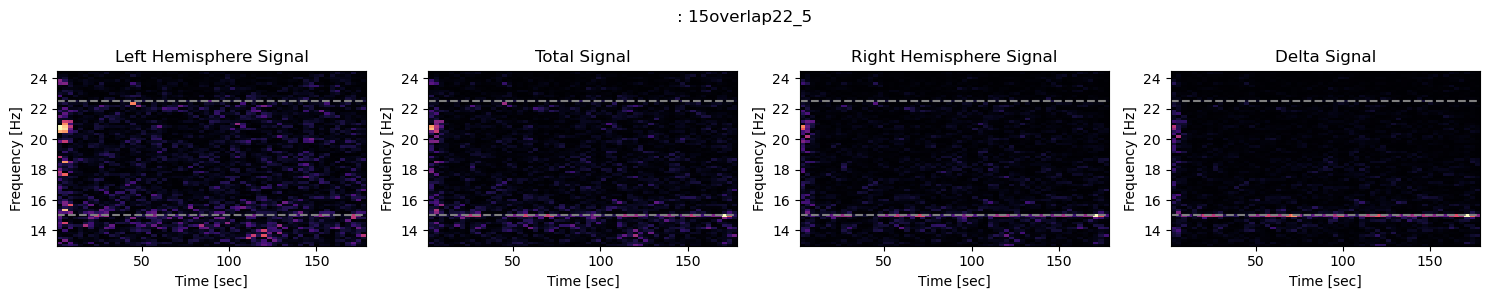

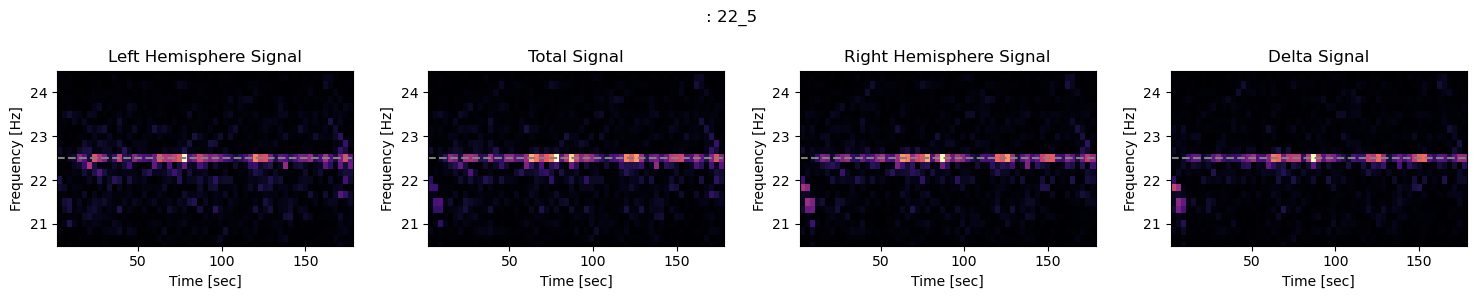

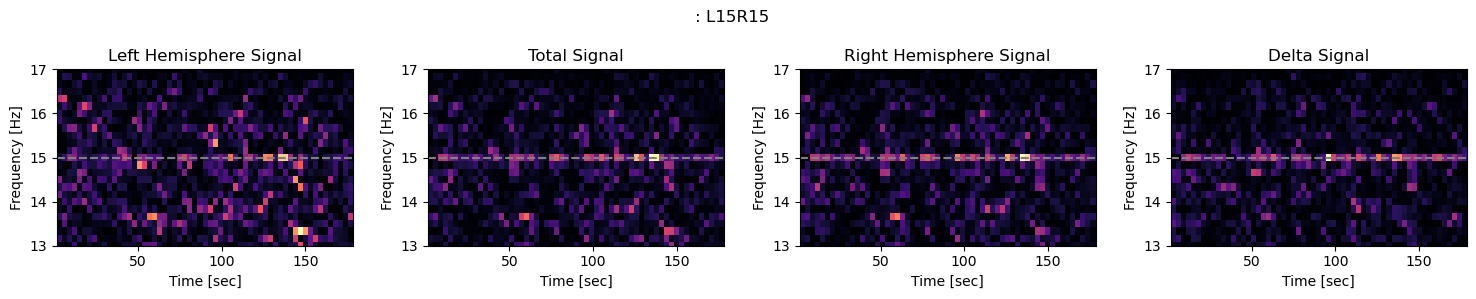

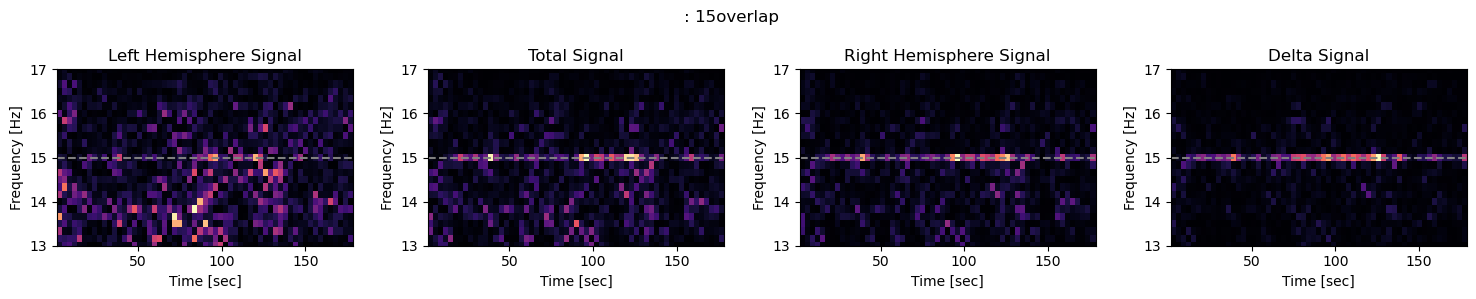

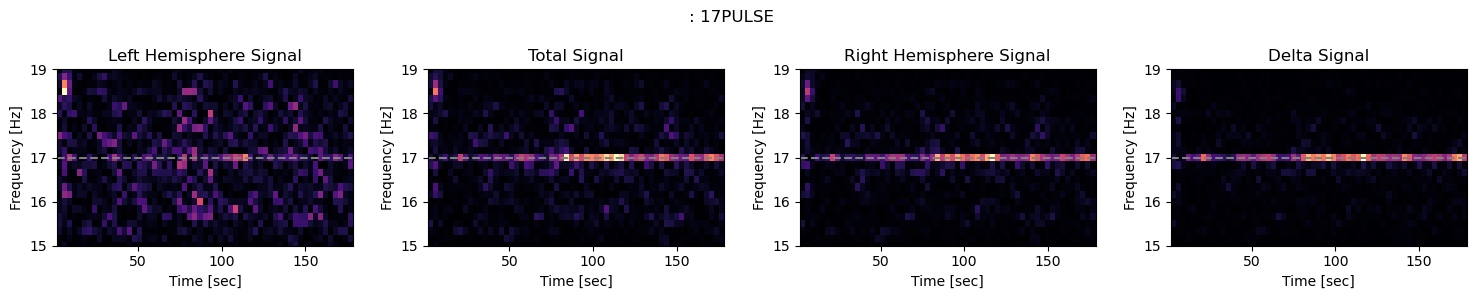

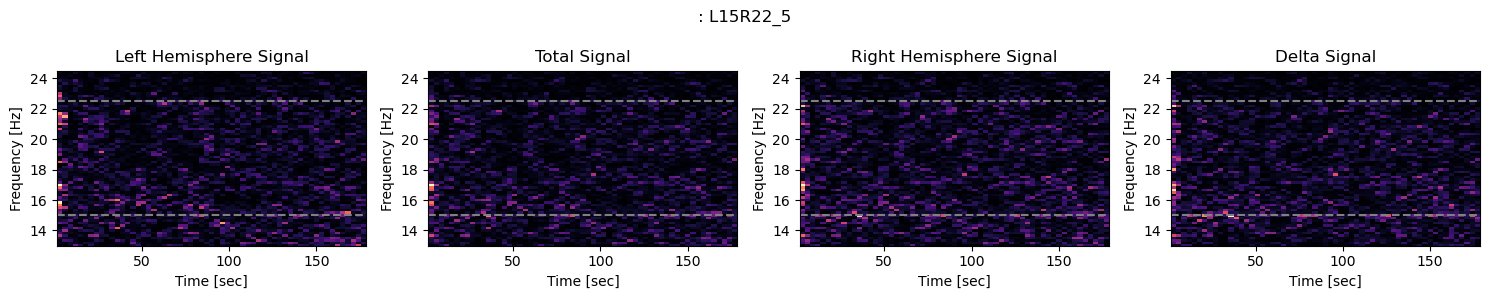

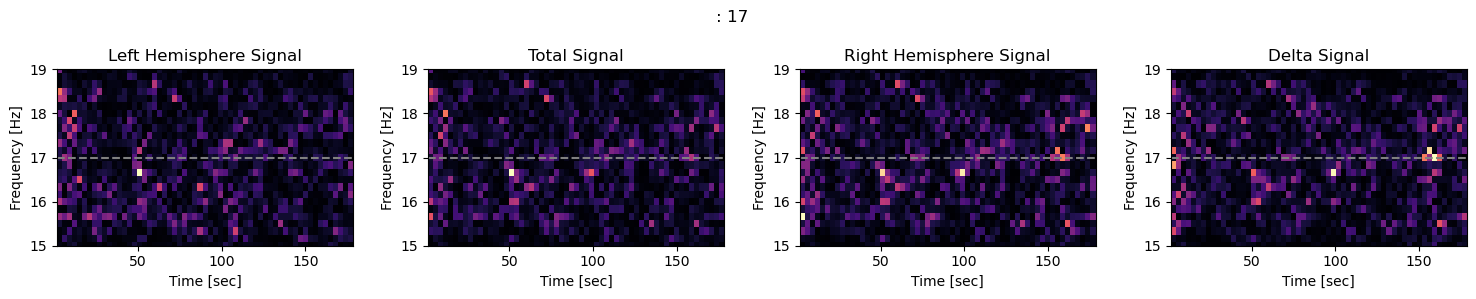

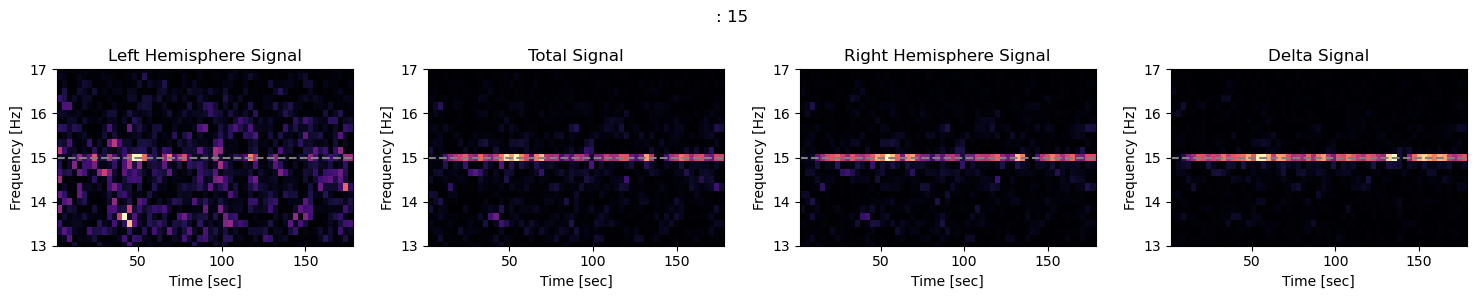

In [99]:
def chan_hemisphere(chan_name):
    # left hemisphere -> odd numbers (1,3,5,7) 
    left_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 != 0]
    # right hemisphere -> even numbers (2,4,6,8)
    right_hemisphere = [chan for chan in chan_name if chan[-1].isdigit() and int(chan[-1]) % 2 == 0]
    # midline -> z
    midline_hemisphere = [chan for chan in chan_name if chan[-1] == 'z']
    return left_hemisphere, midline_hemisphere, right_hemisphere

def hemisphere_signal_avg(eeg, chan_name):
    left_hemisphere, midline_hemisphere, right_hemisphere = chan_hemisphere(chan_name)

    # seperate the signal into left and right hemisphere and take the average per channel
    left_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in left_hemisphere],:], axis=0)
    right_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in right_hemisphere],:], axis=0)
    midline_hemisphere_signal = np.mean(eeg.filtered_signal[[chan_name.index(chan) for chan in midline_hemisphere],:], axis=0)
    
    return left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal

def plot_spectrogram_and_bands(eeg,title=None, band_freqs=None, f_min=5, f_max=15, fs=250):
    if band_freqs:
        f_min = min(band_freqs) - 2
        f_max = max(band_freqs) + 2
    else:
        band_freqs = [f_min, f_max]
    total_signal = np.mean(eeg.filtered_signal, axis=0)
    left_hemisphere_signal, midline_hemisphere_signal, right_hemisphere_signal = hemisphere_signal_avg(eeg, chan_name)

    def masked_spectogram(singal, nperseg=6,nfft=6):
        # filter it first from f_min to f_max
        singal = custom_filter(singal, f_min, f_max, fs, 'bandpass')

        frequencies, times, spectrogram = signal.spectrogram(singal, fs=fs, nperseg=fs*nperseg, noverlap=fs*nperseg/2, scaling='spectrum', mode='psd', nfft=fs*nfft)
        mask = (frequencies >= f_min) & (frequencies <= f_max)
        spectrogram_masked = spectrogram[mask, :]
        frequencies_masked = frequencies[mask]
        return frequencies_masked, times, spectrogram_masked
    
    # Plot the spectrogram using matplotlib
    
    # fig, axs = plt.subplots(nrows=2, ncols=3,figsize=(15, 6))
    fig, axs = plt.subplots(nrows=1, ncols=4,figsize=(15, 3))
    def plot_sepctro(ax, signal, title):
        frequencies_masked, times, spectrogram_masked = masked_spectogram(signal, nperseg=6,nfft=6)
        ax.pcolormesh(times, frequencies_masked, spectrogram_masked, cmap ='magma')
        ax.set_ylim(f_min, f_max)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        ax.set_title(title)
        # add yline for stimulus
        for stim in eeg.stimulus_frequency:
            ax.axhline(y=stim, color='gray', linestyle='--')
    

    plot_sepctro(axs[0], left_hemisphere_signal, 'Left Hemisphere Signal')
    plot_sepctro(axs[1], total_signal, 'Total Signal')
    plot_sepctro(axs[2], right_hemisphere_signal, 'Right Hemisphere Signal')
    plot_sepctro(axs[3], left_hemisphere_signal-right_hemisphere_signal-midline_hemisphere_signal, 'Delta Signal')

    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()
    
for eeg in eeg_data: 
    if('22_5overlap25' in eeg.title):
        plot_spectrogram_and_bands(eeg, title = eeg.title, band_freqs=eeg.stimulus_frequency)